IMDB Project 🍿

# Import lib and data

In [3]:
import pandas as pd 
from pyspark.sql import SparkSession
import os
from pyspark import SparkConf, SparkContext, SQLContext
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import udf, length, when, col, broadcast, desc,row_number
from pyspark.sql.types import BooleanType, IntegerType, LongType, StringType, ArrayType, FloatType, StructType, StructField, DateType
import pyspark.sql.functions as F
from pyspark.sql import Row
from pyspark.sql.functions import pandas_udf
from pyspark.sql.functions import PandasUDFType
from pyspark import StorageLevel
import re

In [4]:
import re
import nltk
import gensim
import pandas as pd
import datetime
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
stop_words = stopwords.words('english') + ['also','may','al','cid','ecid']
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [5]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default='notebook'
import matplotlib.pyplot as plt
import seaborn as sns  
sns.set_style("whitegrid",{'axes.grid' : True, "grid.linestyle": "--","grid.color": ".7"})

In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [7]:
spark = SparkSession.builder\
        .master("local[*]")\
        .appName('imdb')\
        .config("spark.driver.memory", "15")\
        .config("spark.memory.offHeap.enabled",'true')\
        .config("spark.memory.offHeap.size","16g")   \
        .getOrCreate()

In [8]:
reviews = spark.read.parquet('/content/drive/My Drive/imdb/reviews2.parquet')

In [9]:
movies = spark.read.parquet('/content/drive/My Drive/imdb/Titles.parquet')

In [10]:
movies = movies.drop("__index_level_0__")

In [11]:
reviews = reviews.drop("__index_level_0__")

In [ ]:
movies.show(20)

In [ ]:
movies.head(2)

In [ ]:
movies.count()

In [ ]:
reviews.count()

In [ ]:
reviews.show(2)

# Prepocessing movies data

## Release date 

Example data: 

*   'March 1, 1963 (Japan)'
*   '2017 (Greece)'
*   'August 2015 (United States)'
*   None






In [12]:
def preprocess_release_date (rls_date):
  rls_date = str(rls_date) 
  year = None
  month = None 
  day = None
  if rls_date == 'None': 
    pass
  else: 
    m = re.sub(r"[^\w\s]", '',str(rls_date)[:str(rls_date).find('(')]).split()
    print(m)
    if len(m[-1]) == 4 : 
      year = int(m[-1])
    if len(m)>1:
      month = m[0]
    if len(m)>2 : 
      day = int(m[1])
  return Row('year', 'month', 'day')(year, month, day)

In [13]:
# struct to store multiple values
schema_added = StructType([
    StructField("year", IntegerType(), True),
    StructField("month", StringType(), True),
    StructField("day", IntegerType(), True)])

append_preprocess_release_date_udf = F.udf(preprocess_release_date, schema_added)

In [14]:
movies = movies.withColumn("date_release",append_preprocess_release_date_udf("release_date"))\
               .drop("release_date")

In [ ]:
movies.head(2)

## Duration

In [15]:
def preprocess_duration (duration):
  hour_to_min = 0
  min = 0 
  if duration ==None: 
    return duration
  elif re.match("([\d]+) *h", duration):
    hour_to_min =  re.findall("([\d]+) *h", duration)[0]
  if re.match("([\d\w\s\d]+) *m", duration):
    try:
      min =  re.findall("([s\d]+) *m", duration)[0]
    except:
      pass
  duration = int(hour_to_min)*60 + int(min)
  if duration == 0:
      duration = None
  return duration

In [16]:
duration_udf = udf(lambda x: preprocess_duration(x), IntegerType())

In [17]:
movies = movies.withColumn("duration_min",duration_udf("duration"))\
                .drop("duration")
        

In [ ]:
movies.show(2)

+-------+--------------------+------------+--------------------+---------------+---------------+--------------------+---------------+------+-----------------+------------+---------------+---------+-------+--------------------+--------------------+------------+
|     id|               title|origin_title|   country_of_origin|age_restriction|       director|              budget|gross_worldwide|rating|number_of_ratings|user_reviews|crtitic_reviews|titleType|isAdult|              genres|        date_release|duration_min|
+-------+--------------------+------------+--------------------+---------------+---------------+--------------------+---------------+------+-----------------+------------+---------------+---------+-------+--------------------+--------------------+------------+
|9110170|Поворот не туда: ...|  Wrong Turn|United StatesGermany|            18+| Mike P. Nelson|                null|     $4,829,926|   5.5|              29K|         nan|            nan|    movie|      0|     Horror,

## Number_of_ratings

In [18]:
def preprocess_n_ratings (n):
  if re.match("([s\d.d]+) *K", n):
    r = re.findall("([s\d.d]+) *K", n)[0]
    r = int(float(r)*1000)
  elif re.match("([s\d.d]+) *M", n):
    r = re.findall("([s\d.d]+) *M", n)[0]
    r = int(float(r)*1000000)
  elif n ==None:
    return n
  else:
    r = int(n)
  return r

In [19]:
n_ratings_udf = udf(lambda x: preprocess_n_ratings(x), IntegerType())


In [22]:
movies = movies.withColumn("n_ratings",n_ratings_udf("number_of_ratings"))\
                .drop("number_of_ratings")
        

In [ ]:
movies.show(2)

+-------+--------------------+------------+--------------------+---------------+---------------+--------------------+---------------+------+------------+---------------+---------+-------+--------------------+-----------------+--------------------+------------+---------+
|     id|               title|origin_title|   country_of_origin|age_restriction|       director|              budget|gross_worldwide|rating|user_reviews|crtitic_reviews|titleType|isAdult|              genres|__index_level_0__|        date_release|duration_min|n_ratings|
+-------+--------------------+------------+--------------------+---------------+---------------+--------------------+---------------+------+------------+---------------+---------+-------+--------------------+-----------------+--------------------+------------+---------+
|9110170|Поворот не туда: ...|  Wrong Turn|[United States, G...|            18+| Mike P. Nelson|                null|     $4,829,926|   5.5|         nan|            nan|    movie|      0|

## Country_of_origin

In [20]:
def preprocess_country( countries): 
  if  countries == None: 
    return None
  else:
    countries= countries.replace(" ","_")
    countries = re.sub(r"([a-z])([A-Z])", r"\1 \2", countries).split(" ")
    res = []
    for i in countries: 
      res.append(i.replace("_"," "))
    return res 

In [21]:
countries_udf = udf(lambda x: preprocess_country(x), ArrayType(StringType()))

In [23]:
movies = movies.withColumn("country_of_origin",countries_udf("country_of_origin"))\

## Gross 

In [24]:
def preprocess_gross (value):
  if value == None: 
    return None
  else:
    return int(''.join([n for n in value if n.isdigit()]))

In [25]:
gross_udf = udf(lambda x: preprocess_gross(x), IntegerType())

In [26]:
movies = movies.withColumn("gross",gross_udf("gross_worldwide"))\
      .drop("gross_worldwide")

In [ ]:
movies.head(2)

[Row(id=26, title='Партия в карты', origin_title="Partie d'écarté", country_of_origin=['France'], age_restriction=None, director='Louis Lumière', budget=None, gross_worldwide=None, rating=5.699999809265137, user_reviews='8.0', crtitic_reviews='4.0', titleType='short', isAdult='0', genres='Documentary,Short', date_release=Row(year=1896, month='February', day=23), duration_min=1, n_ratings=1500, count_reviews=2),
 Row(id=29, title='Завтрак младенца', origin_title='Repas de bébé', country_of_origin=['France'], age_restriction=None, director='Louis Lumière', budget=None, gross_worldwide=None, rating=5.900000095367432, user_reviews='11.0', crtitic_reviews='5.0', titleType='short', isAdult='0', genres='Documentary,Short', date_release=Row(year=1896, month='July', day=None), duration_min=1, n_ratings=3200, count_reviews=3)]

In [ ]:
movies.show(20)

+--------+--------------------+--------------------+--------------------+---------------+---------+------------------+--------------------+--------------------+---------------+------+-----------------+------------+---------------+------------+-------+--------------------+-----------------+
|      id|               title|        origin_title|   country_of_origin|age_restriction| duration|          director|        release_date|              budget|gross_worldwide|rating|number_of_ratings|user_reviews|crtitic_reviews|   titleType|isAdult|              genres|__index_level_0__|
+--------+--------------------+--------------------+--------------------+---------------+---------+------------------+--------------------+--------------------+---------------+------+-----------------+------------+---------------+------------+-------+--------------------+-----------------+
| 9110170|Поворот не туда: ...|          Wrong Turn|[United States, G...|            18+|   1h 49m|    Mike P. Nelson|February 

## Others

In [27]:
movies = movies.withColumn('crtitic_reviews', 
      when(movies.crtitic_reviews == 'nan',None)\
      .otherwise(movies.crtitic_reviews))

In [28]:
movies = movies.withColumn('rating', F.col('rating').cast(FloatType()))

In [29]:
movies.count()

278900

# Prepocessing reviews data

## Date created

In [30]:
def preprocess_date_created (crt_date):
    d = str(crt_date).split(" ")
    if len(d)==3:
      crt_date = d[2] +"-" + str(datetime.datetime.strptime(d[1], '%B').month).zfill(2) + "-"+ d[0].zfill(2)
    else: 
      pass
    return datetime.datetime.strptime(crt_date,'%Y-%m-%d').date()
@pandas_udf('date')
def preprocessing_date_created_udf(date_created: pd.Series) -> pd.Series:
    return date_created.apply(preprocess_date_created)

In [31]:
reviews = reviews.withColumn('date_created_clean', preprocessing_date_created_udf('date_created')).drop("date_created")

In [32]:
reviews=reviews.withColumnRenamed('date_created_clean','date_created' )

In [33]:
reviews = reviews.withColumn("rating",col("rating").cast(IntegerType())) 

In [ ]:
reviews.show()

+--------+------------------+--------------------+------+------------+
|movie_id|            author|              review|rating|date_created|
+--------+------------------+--------------------+------+------------+
| 5834426|         onze-kris|As the title says...|     1|  2022-04-27|
|13668894|     WatchAndSmile|Big production, b...|     4|  2022-04-27|
| 1990218|     ddiegel-76681|For the genre of ...|     8|  2022-04-27|
| 9110170| mateotorres-36528|The wrong turn fr...|     8|  2022-04-27|
|   76686|        dopefishie|Incredible film! ...|     9|  2022-04-27|
| 1877830|        Chewies624|The Batman is not...|     8|  2022-04-27|
|   50189|        andy-83136|But actually acti...|     7|  2022-04-27|
|   55294|    Weirdling_Wolf|A neat-o, lovably...|     7|  2022-04-27|
| 7537096|         Andy_Eban|Yikes this was la...|     1|  2022-04-27|
| 7773068|     Rodrigo_Amaro|"The Night Was Co...|    10|  2022-04-27|
|  289765|    sparkyhughes33|A good film that ...|     8|  2022-04-27|
|  369

## Preprocessing text

In [34]:
def preprocessing_text(text):
    #first preprocess
    text = text.lower()
    text = re.sub('[^\w0-9\- ]', '', text)
    text = re.sub('_', '', text)
    text = re.sub(' {2,}',' ', text)
    text = re.sub('[0-9]{1,}', ' ', text)
    text = re.sub('(^| )\w{1,2}($| )', ' ', text)
    text = re.sub(' {2,}',' ', text)
    
    #lemmatize
    lemm = WordNetLemmatizer()
    token_text = ' '.join([lemm.lemmatize(word) for word in text.split() if word not in stop_words])
    
    #tokenize
    token_text.split()
    
    return token_text.split()

preprocessing_text_udf = udf(lambda x: preprocessing_text(x), ArrayType(StringType()))

In [35]:
reviews = reviews.withColumn('nice_review', preprocessing_text_udf('review'))

In [ ]:
reviews.count()

5366136

In [ ]:
reviews

DataFrame[movie_id: bigint, author: string, review: string, rating: int, date_created: date, nice_review: array<string>]

In [ ]:
reviews.show(2)

+--------+-------------+--------------------+------+------------+--------------------+
|movie_id|       author|              review|rating|date_created|         nice_review|
+--------+-------------+--------------------+------+------------+--------------------+
| 5834426|    onze-kris|As the title says...|     1|  2022-04-27|[title, say, prem...|
|13668894|WatchAndSmile|Big production, b...|     4|  2022-04-27|[big, production,...|
+--------+-------------+--------------------+------+------------+--------------------+
only showing top 2 rows



# Analysis

## Top titles by number of reviews

In [36]:
movies_top_reviews = reviews.groupBy('movie_id').count()\
                           .withColumnRenamed('count','count_reviews')

movies = movies.join(movies_top_reviews, movies_top_reviews.movie_id == movies.id,'leftouter')\
      .select(movies["*"],movies_top_reviews.count_reviews ).cache()

In [ ]:
movies.select(movies.title, movies.count_reviews)\
    .sort(desc('count_reviews')).head(10)

[Row(title='Чудо-женщина: 1984', count_reviews=12954),
 Row(title='Побег из Шоушенка', count_reviews=12886),
 Row(title='Темный рыцарь', count_reviews=9636),
 Row(title='Мстители: Финал', count_reviews=9313),
 Row(title='Властелин колец: Братство кольца', count_reviews=9145),
 Row(title='Лакшми', count_reviews=8961),
 Row(title='Бедное сердце', count_reviews=7911),
 Row(title='Довод', count_reviews=7565),
 Row(title='Капитан Марвел', count_reviews=7437),
 Row(title='Лига справедливости Зака Снайдера', count_reviews=7250)]

## Number of reviews by Title type/format

In [ ]:
titleType_review = movies.groupBy('titleType')\
      .agg(F.sum('count_reviews').alias('count_reviews'), (F.count('id').alias('count_titles')))\
      .orderBy('count_reviews', ascending=False).show()

+------------+-------------+------------+
|   titleType|count_reviews|count_titles|
+------------+-------------+------------+
|       movie|      4482272|      139328|
|    tvSeries|       366974|       21539|
|   tvEpisode|       168998|       66898|
|tvMiniSeries|        58645|        4159|
|     tvMovie|        58459|       13605|
|       short|        42322|       19644|
|       video|        27978|        7508|
|   videoGame|         9300|        2906|
|   tvSpecial|         8373|        1678|
|        null|         1936|        1234|
|     tvShort|         1378|         401|
+------------+-------------+------------+



In [ ]:
movies.show(2)

+-------+--------------------+------------+--------------------+---------------+--------+---------------+--------------------+--------------------+---------------+------+-----------------+------------+---------------+---------+-------+--------------------+
|     id|               title|origin_title|   country_of_origin|age_restriction|duration|       director|        release_date|              budget|gross_worldwide|rating|number_of_ratings|user_reviews|crtitic_reviews|titleType|isAdult|              genres|
+-------+--------------------+------------+--------------------+---------------+--------+---------------+--------------------+--------------------+---------------+------+-----------------+------------+---------------+---------+-------+--------------------+
|9110170|Поворот не туда: ...|  Wrong Turn|United StatesGermany|            18+|  1h 49m| Mike P. Nelson|February 18, 2021...|                null|     $4,829,926|   5.5|              29K|         nan|            nan|    movie|  

In [ ]:
titleType_review

,titleType,count_reviews
0,movie,1833267
1,tvSeries,366974
2,tvEpisode,168998
3,tvMiniSeries,58645
4,tvMovie,58459
5,short,42322
6,video,27978
7,videoGame,9300
8,tvSpecial,8373
9,None,1936


## Distribution of the number of reviews relative to the rating

In [ ]:
rating_review = reviews.where(F.col('rating').isNotNull()).groupBy('rating')\
      .agg(F.count('review').alias('count_reviews'))\
      .orderBy('count_reviews', ascending=False).toPandas()

Text(0, 0.5, 'Number of reviews')

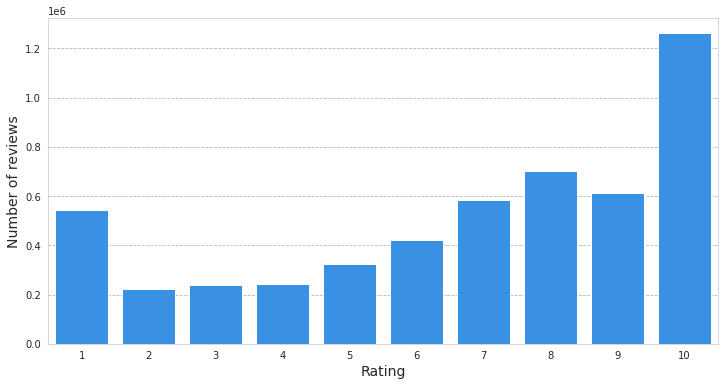

In [ ]:
plt.figure(figsize=(12,6))
sns.set_style("whitegrid",{'axes.grid' : True, "grid.linestyle": "--","grid.color": ".7"})
sns.barplot(y="count_reviews", x="rating",
              data=rating_review,
              orient = 'v',
              color = 'dodgerblue')

plt.xlabel("Rating",fontsize=14)
plt.ylabel("Number of reviews",fontsize=14)
#plt.title("Distribution of the number of reviews relative to the rating") 

## Frequency distribution of words 

### Top 20 adjectives

In [ ]:
def select_adjectives(text):
      selective_pos_words = []
      pos = nltk.pos_tag(text)
      for word,tag in pos:
        if tag.startswith('J') :
          selective_pos_words.append(word)
      return selective_pos_words
select_adjectives_udf = udf(lambda x: select_adjectives(x), ArrayType(StringType()))

In [ ]:
reviews = reviews.withColumn('adjectives', select_adjectives_udf('nice_review'))

In [ ]:
reviews.head(2)

[Row(movie_id=5834426, author='onze-kris', review="As the title says. The premise is daring but nothing makes sense. Even the normal conversations are pretty bad.\n\nI don't know what is worse. But most of what happens is predictable but with bad dialogue.\n\nOne example.\n\nLooting has become a favorite passtime. 8n England.\n\nAVOID.", rating=1, date_created=datetime.date(2022, 4, 27), nice_review=['title', 'say', 'premise', 'daring', 'nothing', 'make', 'sense', 'even', 'normal', 'conversation', 'pretty', 'badi', 'dont', 'know', 'worse', 'happens', 'predictable', 'bad', 'dialogueone', 'examplelooting', 'become', 'favorite', 'passtime', 'englandavoid'], adjectives=['normal', 'badi', 'worse', 'predictable', 'bad', 'favorite']),
 Row(movie_id=13668894, author='WatchAndSmile', review="Big production, beautiful set,but average to bellow average acting. Cheap-looking fight scenes and very, very boring story.\n\nI have no doubt, fanatics will love it and hence the extremely overrated rating

In [ ]:
sqlr=reviews.createOrReplaceTempView('rev')
#sqlr2=movies.createOrReplaceTempView('mov')

In [ ]:
top20_adjectives = spark.sql("""

WITH COUNT_WORDS AS (
      SELECT 
        rating,
        word,
        count_word,
        ROW_NUMBER() OVER(PARTITION BY rating ORDER BY count_word DESC) AS rank
        FROM (
          SELECT
            rating,
            word,
            count(word) AS count_word
          FROM
            (
            SELECT 
              IF(rating>5,"positive","negative") AS rating,
              EXPLODE(adjectives) AS word
            FROM  rev 
            WHERE rating>9 OR rating<2
            LIMIT 500000
           
            ) w
          WHERE word NOT IN ('dont', 'even' , 'never' , '-', 'ive' , 'cant', 'one', 'film',
           'movie','series', 'story', 'much','really','would','episode','character','time', 'get',
           'see','show','watch','watching', 'know','scene','make','people','ever','plot','first', 'could',
           'something','season','think','didnt','minute','say','whole','new','last','good','true','second','many'	)
          GROUP BY rating,word
          ORDER BY rating,count_word desc
          ) c
  )
  SELECT 
    rating,
    word,
    count_word
  FROM COUNT_WORDS
  WHERE rank<=20
 """).toPandas()

In [ ]:
top20_adjectives_n =top20_adjectives[top20_adjectives['rating']=='negative'][['word','count_word']].set_index('word').T.to_dict('records')
top20_adjectives_p =top20_adjectives[top20_adjectives['rating']=='positive'][['word','count_word']].set_index('word').T.to_dict('records')

In [ ]:
import wordcloud
from wordcloud import WordCloud

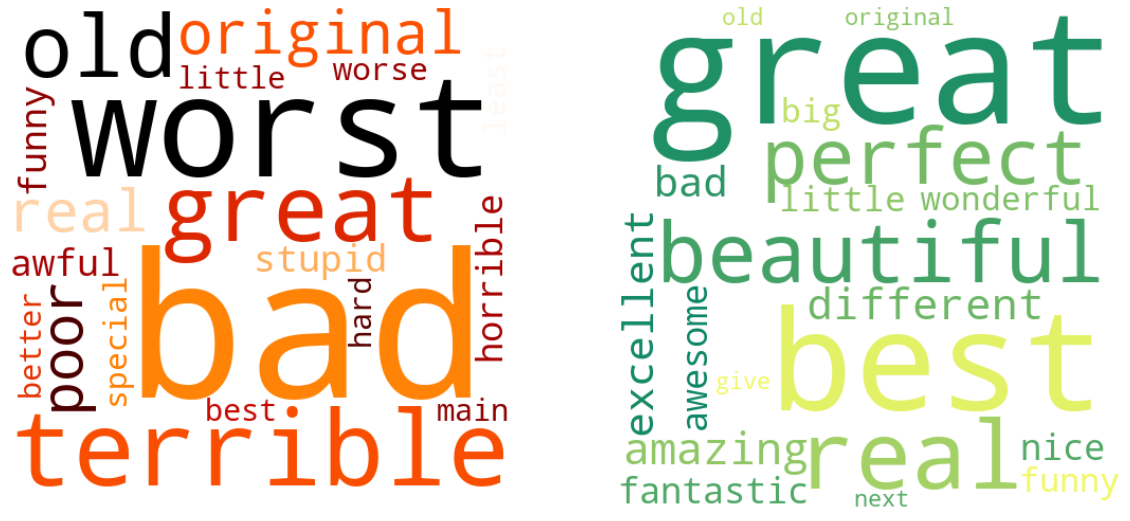

In [ ]:
wordcloud_negative = WordCloud(width=480, height=480, background_color="white",colormap="gist_heat")
wordcloud_positive = WordCloud(width=480, height=480, background_color="white",colormap="summer")
wordcloud_negative.generate_from_frequencies(frequencies=top20_adjectives_n[0])
wordcloud_positive.generate_from_frequencies(frequencies=top20_adjectives_p[0])

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20, 10))
ax1.imshow(wordcloud_negative, interpolation="bilinear")
ax2.imshow(wordcloud_positive, interpolation="bilinear")
ax1.axis("off")
ax2.axis("off")
plt.show()

## The dependence of the average rating on the number of votes

In [ ]:
raiting_m = movies.select(movies.rating,movies.n_ratings ).where((movies.rating.isNotNull()) &(movies.n_ratings .isNotNull())).toPandas()

Text(0.5, 1.0, 'The dependence of the average rating on the number of votes')

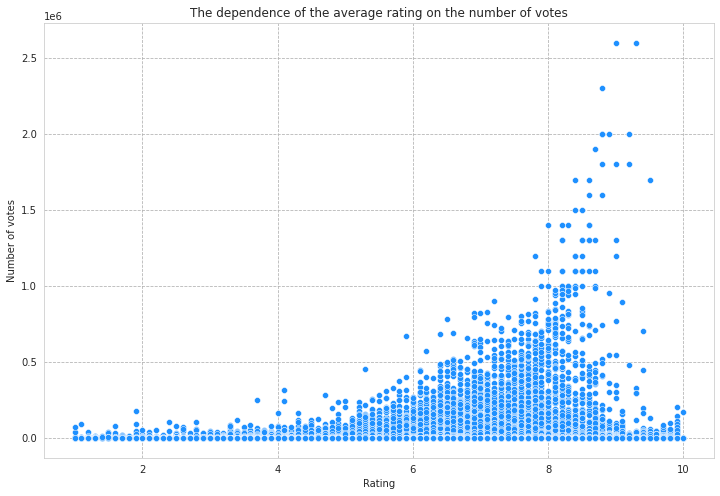

In [ ]:
plt.figure(figsize=(12,8))
sns.scatterplot(data= raiting_m , x="rating", y="n_ratings",color = 'dodgerblue')
plt.xlabel("Rating")
plt.ylabel("Number of votes")
plt.title("The dependence of the average rating on the number of votes") 

Number of unique users and top users by reviews

In [ ]:
 reviews.select( reviews.author).distinct().count()

958947

In [ ]:
 author_review = reviews.groupBy('author')\
      .agg(F.count('review').alias('count_reviews'), F.avg('rating').alias('avg_raiting'))\
      .orderBy('count_reviews', ascending=False).toPandas()

In [ ]:
author_review 

,author,count_reviews,avg_raiting
0,planktonrules,13719,6.008310
1,TheLittleSongbird,13177,7.445549
2,bkoganbing,10449,5.969854
3,SnoopyStyle,9939,6.121139
4,Hitchcoc,7146,7.747131
...,...,...,...
958942,michaelpatrickhart,1,7.000000
958943,pipeorganut,1,8.000000
958944,ambassadoryanek,1,9.000000
958945,hsolo-1,1,10.000000


## Number of reviews  by year

In [ ]:
date_reviews = reviews.withColumn('year_created',F.year(F.col('date_created'))).\
                                  groupBy('year_created').agg(F.count('review').alias('count_reviews')).toPandas()

In [ ]:
sns.set_style("whitegrid",{'axes.grid' : True, "grid.linestyle": "--","grid.color": ".7"})

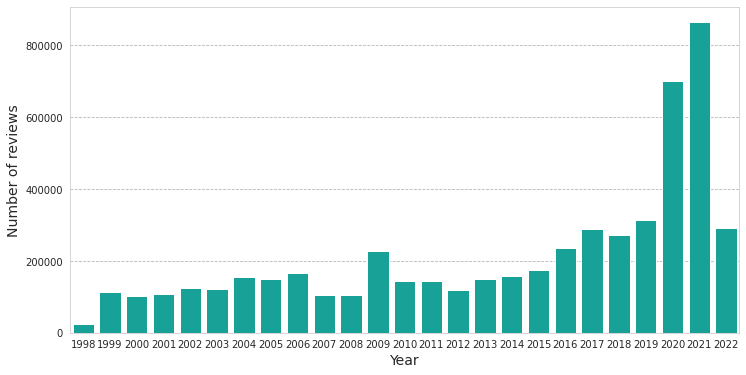

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(x = "year_created", y = "count_reviews", data = date_reviews , color = '#01b8aa')
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of reviews",fontsize=14)
#plt.title("Reviews count per year", fontsize=14)
plt.show()

## Number of titles by year

In [ ]:
def year_interval (rls_year):
  start = rls_year//10*10
  end = rls_year//10*10+9
  return str(start)+"-"+str(end)
  

In [ ]:
year_interval_udf = udf(lambda x:  year_interval (x), StringType())

In [ ]:
date_movies = movies.filter(movies.date_release.year.isNotNull()).\
                  withColumn("interval",year_interval_udf("date_release.year")).\
                   groupBy("interval").agg(F.count('id').alias('count_titles')).\
                   orderBy("interval", ascending=True).\
                   toPandas()

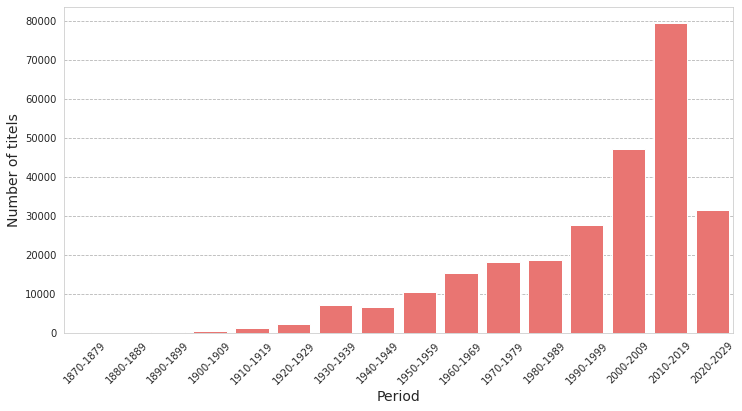

In [ ]:
plt.figure(figsize=(12,6))
plt.xticks(rotation=45)
sns.barplot(x = "interval", y = "count_titles", data = date_movies  , color = '#fd625e')
plt.xlabel("Period",fontsize=14)
plt.ylabel("Number of titels",fontsize=14)
#plt.title("Titles count per 10 year interval",fontsize=14)
plt.show()

## Distribution of Duration

In [ ]:
duration_movies = movies.where((movies.titleType == 'movie') &(movies.duration_min <=300)).select(movies.duration_min).toPandas()

In [ ]:
duration_series = movies.where((movies.titleType == 'tvMiniSeries') &(movies.duration_min <=300)).select(movies.duration_min).toPandas()

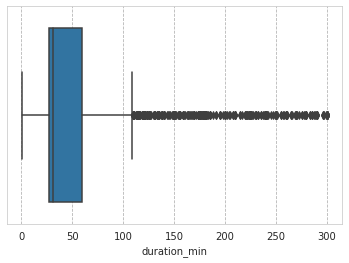

In [ ]:
sns.boxplot(x=duration_movies["duration_min"])

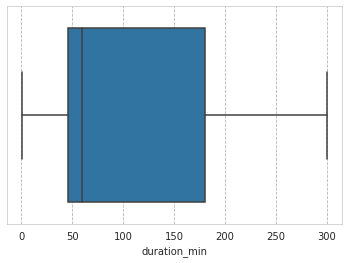

In [ ]:
sns.boxplot(x=duration_series["duration_min"])

The most common movie duration is 90 minutes

In [ ]:
movies.where((movies.titleType == 'movie') &(movies.duration_min <=400)).select(movies.duration_min).groupBy(movies.duration_min).count().\
   orderBy('count', ascending=False).show()

+------------+-----+
|duration_min|count|
+------------+-----+
|          90| 8386|
|          95| 4432|
|         100| 4071|
|          85| 3964|
|          92| 3570|
|          93| 3504|
|          80| 3419|
|          88| 3371|
|          94| 3094|
|          91| 3043|
|          96| 3003|
|          87| 2963|
|          98| 2852|
|          89| 2849|
|          97| 2840|
|          86| 2788|
|         105| 2634|
|          84| 2373|
|          82| 2308|
|         110| 2174|
+------------+-----+
only showing top 20 rows



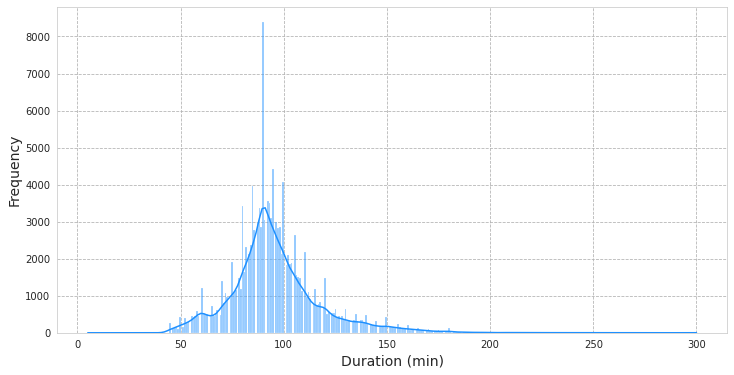

In [ ]:

plt.figure(figsize=(12,6))
sns.histplot(data=duration_movies, x="duration_min", kde=True, color="dodgerblue")
plt.ylabel("Frequency",fontsize=14)
plt.xlabel("Duration (min)",fontsize=14)
plt.show()

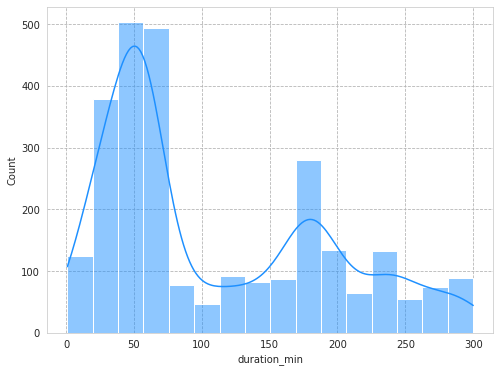

In [ ]:
plt.figure(figsize=(8,6))
sns.histplot(data=duration_series, x="duration_min", kde=True, color="dodgerblue")

plt.show()

## Genres analysis

In [37]:
genres = movies.select("*").withColumn("GenresArray", F.split(F.col("genres"),",")).drop("genres")


In [38]:
genres_split = genres.withColumn('genres', F.explode('GenresArray')).drop("GenresArray")

In [39]:
genres_split.show(10)

+----+-------------------+---------------+-----------------+---------------+--------------------+------+------+------------+---------------+---------+-------+--------------------+------------+---------+-----+-------------+-----------+
|  id|              title|   origin_title|country_of_origin|age_restriction|            director|budget|rating|user_reviews|crtitic_reviews|titleType|isAdult|        date_release|duration_min|n_ratings|gross|count_reviews|     genres|
+----+-------------------+---------------+-----------------+---------------+--------------------+------+------+------------+---------------+---------+-------+--------------------+------------+---------+-----+-------------+-----------+
|  26|     Партия в карты|Partie d'écarté|         [France]|           null|       Louis Lumière|  null|   5.7|         8.0|            4.0|    short|      0|{1896, February, 23}|           1|     1500| null|            2|Documentary|
|  26|     Партия в карты|Partie d'écarté|         [France]|

In [40]:
film_count = genres_split.groupBy('genres').agg(F.count('title').alias('count_films')).orderBy('count_films', ascending=False).toPandas()

In [ ]:

film_count.head(10)

,genres,count_films
0,Drama,121779
1,Comedy,81493
2,Crime,41635
3,Action,38950
4,Adventure,28870
5,Documentary,28834
6,Romance,26001
7,Thriller,21951
8,Horror,21676
9,Mystery,21667


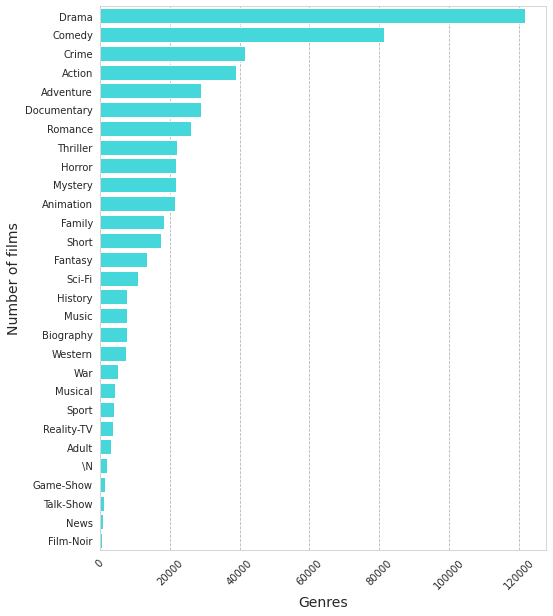

In [ ]:
plt.figure(figsize=(8,10))
plt.xticks(rotation=45)
sns.barplot(y = "genres", x = "count_films", data = film_count  , color = '#2DEEF4',orient="h")
plt.xlabel("Genres",fontsize=14)
plt.ylabel("Number of films",fontsize=14)

#plt.title("Number of films by genres",fontsize=14)
plt.show()

In [ ]:
genres_split.show()

+--------+--------------------+--------------------+--------------------+---------------+------------------+--------------------+------+------------+---------------+---------+-------+--------------------+------------+---------+---------+---------+
|      id|               title|        origin_title|   country_of_origin|age_restriction|          director|              budget|rating|user_reviews|crtitic_reviews|titleType|isAdult|        date_release|duration_min|n_ratings|    gross|   genres|
+--------+--------------------+--------------------+--------------------+---------------+------------------+--------------------+------+------------+---------------+---------+-------+--------------------+------------+---------+---------+---------+
| 9110170|Поворот не туда: ...|          Wrong Turn|United StatesGermany|            18+|    Mike P. Nelson|                null|   5.5|         nan|           null|    movie|      0|{2021, February, 18}|         109|    29000|  4829926|   Horror|
| 911017

In [48]:
reviews_count = genres_split.groupBy('genres').agg(F.sum('count_reviews').alias('count_reviews')).orderBy('count_reviews', ascending=False).toPandas()

In [ ]:
reviews_count.head(10)

,genres,count_reviews
0,Drama,2632108
1,Action,1576952
2,Comedy,1408050
3,Adventure,1133670
4,Crime,908716
5,Thriller,832650
6,Horror,723832
7,Romance,599498
8,Sci-Fi,592654
9,Mystery,556977


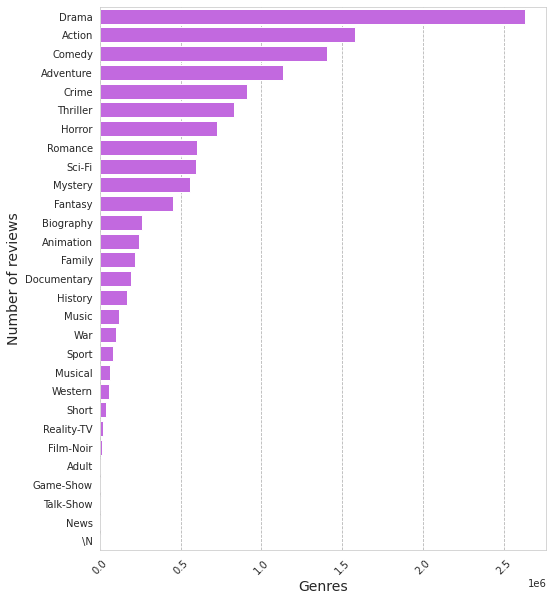

In [ ]:
plt.figure(figsize=(8,10))
plt.xticks(rotation=45)
sns.barplot(y = "genres", x = "count_reviews", data = reviews_count  , color = '#CC56F2',orient="h")
plt.xlabel("Genres",fontsize=14)
plt.ylabel("Number of reviews",fontsize=14)
#plt.title("Number of reviews by genres",fontsize=14)
plt.show()

In [49]:
film_review_genre = film_count.merge(reviews_count, left_on = 'genres', right_on = 'genres' , how ='inner')

In [ ]:
film_review_genre = film_review_genre.set_index('genres')

In [ ]:
film_review_genre.shape

(29, 2)

In [ ]:



color_red = '#fd625e'
color_blue = '#01b8aa'
index = film_review_genre.index
column0 = film_review_genre['count_films']
column1 = film_review_genre['count_reviews']
title0 = 'Titles'
title1 = 'Reviews'

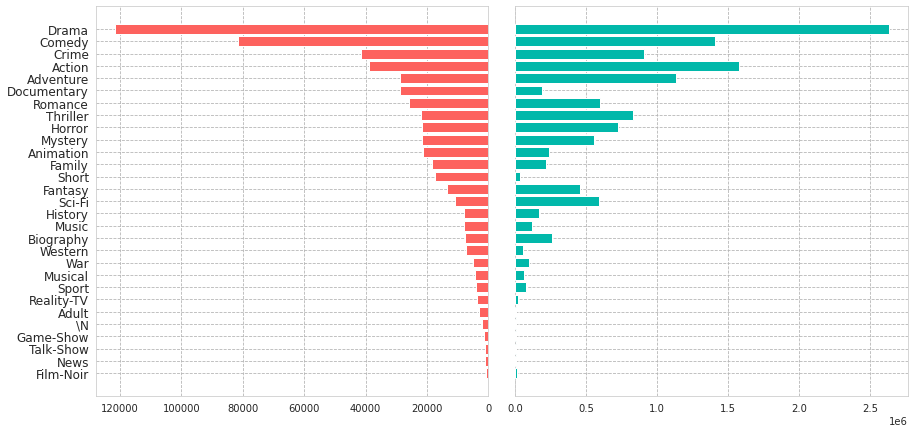

In [ ]:
fig, axes = plt.subplots(figsize=(12,6), ncols=2, sharey=True)
fig.tight_layout()
axes[0].barh(index, column0, align='center', color=color_red, zorder=10)
#axes[0].set_title(title0, fontsize=15, pad=15, color='#4a4a4a', **hfont)
axes[1].barh(index, column1, align='center', color=color_blue, zorder=10)
#axes[1].set_title(title1, fontsize=15, pad=15, color='#4a4a4a', **hfont)
# To show data from highest to lowest
axes[0].invert_xaxis() 
plt.gca().invert_yaxis()
            
axes[0].set(yticks=film_review_genre.index, yticklabels=film_review_genre.index)
#axes[0].yaxis.tick_left()
axes[0].tick_params(axis='y', labelsize=12) # tick color

Group movies by genre and year with average rating

In [42]:
avg_rating_by_genres_years = genres_split.groupBy('genres', "date_release.year").agg(F.avg('rating').alias("average_rating"))

In [43]:
avg_rating_by_genres_years.show(10)

+------+----+------------------+
|genres|year|    average_rating|
+------+----+------------------+
|Sci-Fi|1956| 6.411940325551958|
| Crime|1989| 6.617512689629182|
|Action|1977| 6.360126585900029|
|Family|2010| 6.273897063644493|
| Drama|1951| 6.562177651932725|
| Short|1978| 6.059523809523809|
| Crime|2006| 6.999000004529953|
| Drama|1968|6.6673913094876465|
|Comedy|2010| 6.420503598923306|
| Short|2015|  7.22676057479751|
+------+----+------------------+
only showing top 10 rows



In [44]:
avg_rating_by_genres_years.where(avg_rating_by_genres_years.genres == "Drama").orderBy("year").show(10)

+------+----+-----------------+
|genres|year|   average_rating|
+------+----+-----------------+
| Drama|null|6.423249213778258|
| Drama|1894|5.599999904632568|
| Drama|1896|5.700000047683716|
| Drama|1897|4.566666762034099|
| Drama|1898|              5.0|
| Drama|1899|5.575000047683716|
| Drama|1900|6.174999952316284|
| Drama|1901|5.519999980926514|
| Drama|1902|5.849999984105428|
| Drama|1903|5.949999988079071|
+------+----+-----------------+
only showing top 10 rows



In [45]:
genres_set = avg_rating_by_genres_years.select(F.collect_set(avg_rating_by_genres_years.genres).alias("genres_set")).toPandas()

In [ ]:
print(genres_set.genres_set.values)
print(len(genres_set.genres_set.values[0]))

[list(['Thriller', 'Game-Show', 'Action', 'Crime', 'Comedy', 'News', 'Horror', 'Animation', 'Western', 'Documentary', 'Mystery', 'Romance', 'Sport', 'Reality-TV', 'Musical', 'History', 'Adventure', 'Film-Noir', 'Biography', 'Music', '\\N', 'Talk-Show', 'Short', 'War', 'Fantasy', 'Drama', 'Family', 'Adult', 'Sci-Fi'])]
29


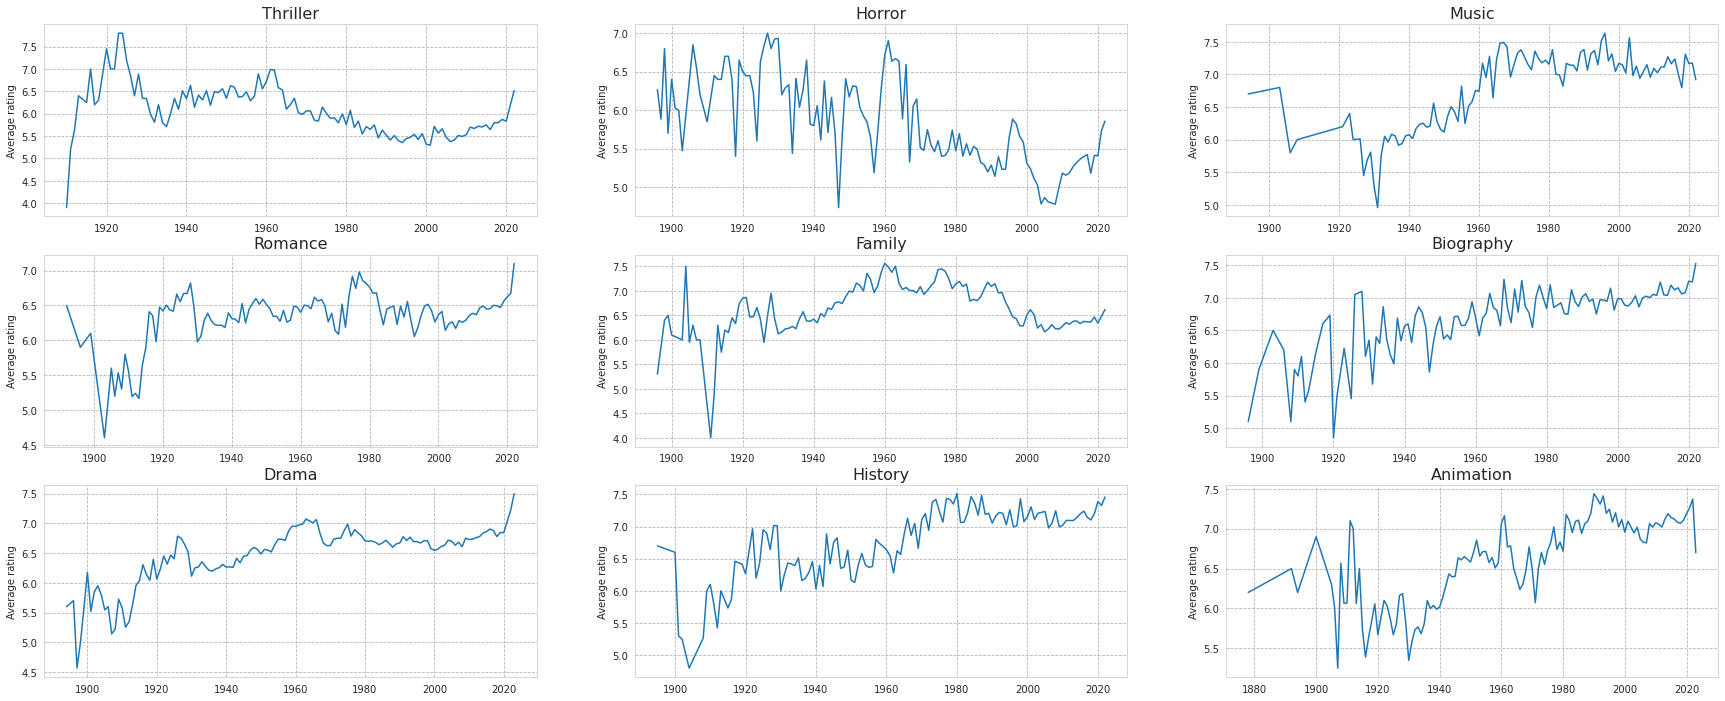

In [53]:
list_genres = ['Thriller', 'Horror', 'Music', 'Romance', 'Family', 'Biography','Drama', "History", "Animation"]
def get_pd(genre_name):
  return avg_rating_by_genres_years.where(avg_rating_by_genres_years.genres == genre_name).orderBy("year").toPandas()
fig1, axes = plt.subplots(3, 3, figsize=(30, 12))
for i, genre in enumerate(list_genres) :
    ax = axes[i // 3, i%3]
    if genre != '\\N':
      av_by_year = get_pd(genre)
      year, av_rating = [], []
      for idx, year_ in enumerate(av_by_year.year.values):
        if year is not None:
          year.append(year_)
          av_rating.append(av_by_year.average_rating.values[idx])
      ax.plot(year, av_rating)
      ax.set_title(genre, fontsize=16)
      ax.set( ylabel='Average rating')

plt.show()

In [ ]:
reviews.show(2)

+--------+-------------+--------------------+------+------------+--------------------+
|movie_id|       author|              review|rating|date_created|         nice_review|
+--------+-------------+--------------------+------+------------+--------------------+
| 5834426|    onze-kris|As the title says...|     1|  2022-04-27|[title, say, prem...|
|13668894|WatchAndSmile|Big production, b...|     4|  2022-04-27|[big, production,...|
+--------+-------------+--------------------+------+------------+--------------------+
only showing top 2 rows



## Authors analysis

In [ ]:
reviews.select(F.countDistinct("author")).show()

+----------------------+
|count(DISTINCT author)|
+----------------------+
|               1596186|
+----------------------+



In [ ]:
review_and_rating_authors = reviews.withColumn('label', F.when(F.col('rating')>5, "positive").otherwise("negative"))\
        .groupBy('author').pivot('label')\
        .agg(F.count('review'), F.avg('rating'))\
 

In [ ]:
base_stats = reviews.groupBy('author')\
        .agg(F.min('date_created').alias('first_date_created'),\
             F.max('date_created').alias('last_date_created'),\
             F.avg('rating').alias('avg_rating'))\
        .withColumn("lifetime (days)", F.datediff(F.col('last_date_created'),F.col('first_date_created'))).\
        withColumn('avg_rating',F.round(F.col('avg_rating'),2)).\
         withColumnRenamed('author','author_name')
 

In [ ]:
base_stats.show(2)

+--------------+------------------+-----------------+----------+--------+
|   author_name|first_date_created|last_date_created|avg_rating|datediff|
+--------------+------------------+-----------------+----------+--------+
|theognis-80821|        2019-01-07|       2022-05-17|      6.12|    1226|
|   hyemarkarit|        2022-04-27|       2022-04-27|       1.0|       0|
+--------------+------------------+-----------------+----------+--------+
only showing top 2 rows



In [ ]:
authors_stats = review_and_rating_authors.withColumn('negative_count(review)', F.when(F.col('negative_count(review)').isNull(), 0).otherwise(F.col('negative_count(review)')) )\
              .withColumn('positive_count(review)', F.when(F.col('positive_count(review)').isNull(), 0).otherwise(F.col('positive_count(review)')) )\
              .withColumn("total_reviews", F.col('positive_count(review)') +  F.col('negative_count(review)'))\
              .withColumn("neg_reviews %", F.round(F.col('negative_count(review)')/ F.col("total_reviews"),2))\
              .withColumn("pos_reviews %", F.round(F.col('positive_count(review)')/ F.col("total_reviews"),2))\
              .withColumn("pos_avg(rating)", F.round(F.col('positive_avg(rating)'),2))\
              .withColumn("neg_avg(rating)", F.round(F.col('negative_avg(rating)'),2))\
              .withColumnRenamed('positive_count(review)', 'pos_reviews')\
              .withColumnRenamed('negative_count(review)', 'neg_reviews')\
              .join(base_stats,base_stats.author_name ==  review_and_rating_authors.author,"inner" )\
              .drop(F.col('author_name'))\
              .select('author','lifetime (days)','total_reviews',\
                      'avg_rating',"pos_reviews %", "neg_reviews %", 'pos_reviews','neg_reviews','pos_avg(rating)','neg_avg(rating)',\
                      )\
              .orderBy('total_reviews', ascending=False)
                        

In [ ]:
count_review_authors = authors_stats.groupBy("total_reviews").agg(F.count('author').alias('count_authors')).toPandas()

In [ ]:
authors_stats.show(20)

+-----------------+---------------+-------------+----------+-------------+-------------+-----------+-----------+---------------+---------------+
|           author|lifetime (days)|total_reviews|avg_rating|pos_reviews %|neg_reviews %|pos_reviews|neg_reviews|pos_avg(rating)|neg_avg(rating)|
+-----------------+---------------+-------------+----------+-------------+-------------+-----------+-----------+---------------+---------------+
|      SnoopyStyle|           6739|        17891|      6.05|         0.68|         0.32|      12187|       5704|           6.83|           4.37|
|TheLittleSongbird|           4851|        16422|      7.18|         0.77|         0.23|      12663|       3759|            8.3|           3.43|
|    planktonrules|           6922|        13719|      6.01|         0.64|         0.36|       8794|       4925|           7.44|           3.46|
|       bkoganbing|           6297|        13040|      5.98|         0.65|         0.35|       8461|       4579|            7.0|  

In [ ]:
authors_info = authors_stats.toPandas()

In [ ]:

plt.figure(figsize=(12,6))
sns.histplot(data=authors_info, x="total_reviews",  color="dodgerblue")
plt.ylabel("Frequency",fontsize=14)
plt.xlabel("Duration (min)",fontsize=14)
plt.show()

In [ ]:
count_review_authors[count_review_authors['total_reviews']>100]['count_authors'].sum()

3619

In [ ]:
(3619/1596186)*100

0.22672796278127988

In [ ]:
authors_info

,author,first_date_created,last_date_created,datediff,total_reviews,avg_rating,positive_count(review),positive_count(review) %,positive_avg(rating),negative_count(review),negative_count(review) %,negative_avg(rating)
0,robh,1998-07-28,2022-05-17,8694,61,5.590164,34,0.557377,7.088235,27,0.442623,3.703704
1,pebsdad,1998-08-05,2022-05-11,8680,47,6.063830,28,0.595745,8.285714,19,0.404255,2.789474
2,Scott-12,1998-08-04,2022-05-06,8676,5,7.600000,3,0.600000,10.000000,2,0.400000,4.000000
3,Gislef,1998-08-11,2022-04-25,8658,349,5.501466,202,0.578797,7.292079,147,0.421203,2.899281
4,PatrynXX,1998-09-07,2022-05-20,8656,318,6.854430,231,0.726415,7.900433,87,0.273585,4.011765
...,...,...,...,...,...,...,...,...,...,...,...,...
1596181,zzzzzzippp,2001-01-24,2001-01-24,0,1,NaN,0,0.000000,NaN,1,1.000000,NaN
1596182,{goat},2000-03-19,2000-03-19,0,3,7.333333,3,1.000000,7.333333,0,0.000000,NaN
1596183,~Mandy~,1999-08-20,1999-08-20,0,2,NaN,0,0.000000,NaN,2,1.000000,NaN
1596184,GRËNDEL,1999-01-07,1999-01-07,0,1,10.000000,1,1.000000,10.000000,0,0.000000,NaN


In [ ]:
count_review_authors=count_review_authors.sort_values('total_reviews')

Text(0, 0.5, 'Count authors')

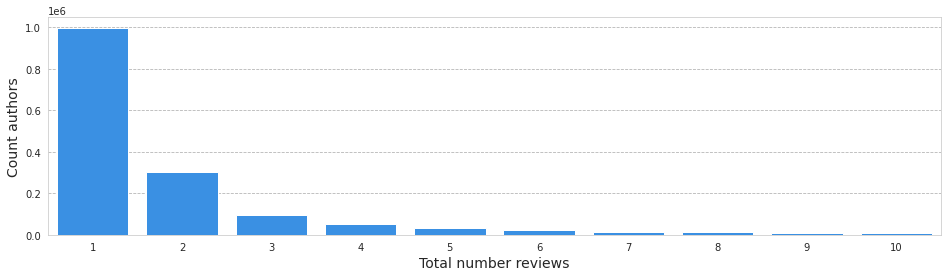

In [ ]:
plt.figure(figsize=(16,4))
sns.set_style("whitegrid",{'axes.grid' : True, "grid.linestyle": "--","grid.color": ".7"})
sns.barplot(y="count_authors", x="total_reviews",
              data=count_review_authors[:10] ,
              orient = 'v',
              color = 'dodgerblue')

plt.xlabel("Total number reviews",fontsize=14)
plt.ylabel("Count authors",fontsize=14)


## Сountries analysis

In [ ]:
movies.show()

+--------+--------------------+--------------------+--------------------+---------------+------------------+--------------------+------+------------+---------------+------------+-------+--------------------+-----------------+--------------------+------------+---------+----------+
|      id|               title|        origin_title|   country_of_origin|age_restriction|          director|              budget|rating|user_reviews|crtitic_reviews|   titleType|isAdult|              genres|__index_level_0__|        date_release|duration_min|n_ratings|     gross|
+--------+--------------------+--------------------+--------------------+---------------+------------------+--------------------+------+------------+---------------+------------+-------+--------------------+-----------------+--------------------+------------+---------+----------+
| 9110170|Поворот не туда: ...|          Wrong Turn|[United States, G...|            18+|    Mike P. Nelson|                null|   5.5|         nan|        

In [ ]:

windowSpecC  = Window.partitionBy('country_of_origin').orderBy(F.col('count_films').desc())

In [ ]:
movies.withColumn('country_of_origin', F.explode('country_of_origin'))\
      .groupBy('country_of_origin').agg(F.count('title').alias('count_films')).orderBy('count_films', ascending=False).show()

+-----------------+-----------+
|country_of_origin|count_films|
+-----------------+-----------+
|    United States|     136402|
|   United Kingdom|      30865|
|           France|      13879|
|           Canada|      13659|
|            India|      13093|
|            Japan|       9075|
|            Italy|       7467|
|          Germany|       6978|
|            Spain|       4772|
|        Australia|       4320|
|        Hong Kong|       3191|
|           Mexico|       2640|
|      South Korea|       2524|
|     West Germany|       2314|
|           Sweden|       2208|
|            China|       2200|
|           Brazil|       2115|
|          Belgium|       2046|
|      Netherlands|       1816|
|           Turkey|       1783|
+-----------------+-----------+
only showing top 20 rows



In [ ]:
movies_countries = movies.withColumn('country_of_origin', F.explode('country_of_origin'))\
      .withColumn("genres", F.split(F.col("genres"),","))\
      .withColumn('genres', F.explode('genres'))\
      .groupBy('country_of_origin','genres').agg(F.count('title').alias('count_films'))\
      .withColumn("row_number_c",row_number().over(windowSpecC))\
      .withColumn('top5_genres',when(F.col('row_number_c')<=10,F.col('genres')).otherwise("Other"))\
      .where(F.col('top5_genres')!='Other')\
      .groupBy('country_of_origin','top5_genres').agg(F.sum(F.col('count_films')).alias('count_films'))\
      .orderBy('count_films', ascending=False).toPandas()

In [ ]:
t = movies_countries[movies_countries['country_of_origin']=='Germany']

In [ ]:
colors = ['#406CFF','#F3A30F','#0FCDF3','#F35CFF','#67E9D5','#fd625e', '#01b8aa','#6789E9','#71DC90','#EDF54D','#F54DE5']

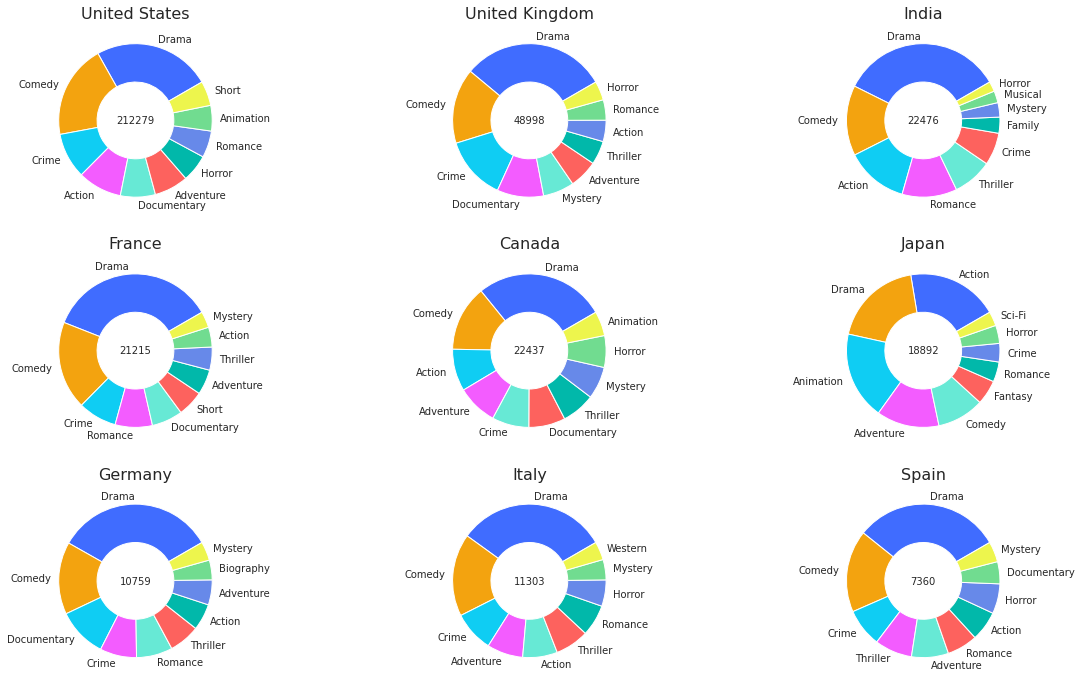

In [ ]:
fig1, axes = plt.subplots(3, 3, figsize=(20, 12))
for i, c in enumerate(movies_countries['country_of_origin'].unique()[:9]) :
    ax = axes[i // 3, i%3 ]
    m = movies_countries[ movies_countries['country_of_origin']==c]
    values = m.count_films
    labels = m.top5_genres
    ax.pie( values, labels = labels,startangle=30,wedgeprops=dict(width=.5),colors=colors )
    ax.set_title(c, fontsize=16)
    ax.text(0., 0., str(values.sum()), horizontalalignment='center', verticalalignment='center')

plt.show()

In [ ]:
movies_country_year = movies.withColumn('country_of_origin', F.explode('country_of_origin'))\
      .groupBy('country_of_origin', 'date_release.year').agg(F.count('title').alias('count_films'))\
      .where(F.col('date_release.year').isNotNull()).orderBy('count_films', ascending=False).toPandas()

In [ ]:
movies_country_year

,country_of_origin,year,count_films
0,United States,2021,5333
1,United States,2020,4973
2,United States,2017,4732
3,United States,2019,4665
4,United States,2016,4341
...,...,...,...
6289,Tajikistan,1995,1
6290,Argentina,1966,1
6291,China,1970,1
6292,China,1976,1


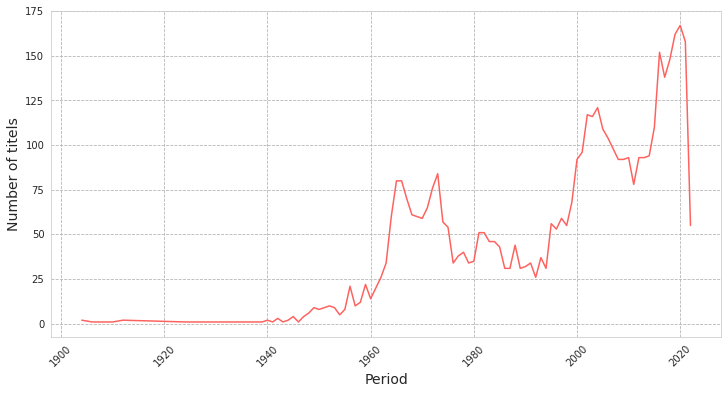

In [ ]:
plt.figure(figsize=(12,6))
plt.xticks(rotation=45)
sns.lineplot(x = "year", y = "count_films", data = movies_country_year[movies_country_year['country_of_origin']=='Spain']  , color = '#fd625e')
plt.xlabel("Period",fontsize=14)
plt.ylabel("Number of titels",fontsize=14)
#plt.title("Titles count per 10 year interval",fontsize=14)
plt.show()

In [ ]:
movies.show()

+--------+--------------------+--------------------+--------------------+---------------+------------------+--------------------+------+------------+---------------+------------+-------+--------------------+-----------------+--------------------+------------+---------+----------+
|      id|               title|        origin_title|   country_of_origin|age_restriction|          director|              budget|rating|user_reviews|crtitic_reviews|   titleType|isAdult|              genres|__index_level_0__|        date_release|duration_min|n_ratings|     gross|
+--------+--------------------+--------------------+--------------------+---------------+------------------+--------------------+------+------------+---------------+------------+-------+--------------------+-----------------+--------------------+------------+---------+----------+
| 9110170|Поворот не туда: ...|          Wrong Turn|[United States, G...|            18+|    Mike P. Nelson|                null|   5.5|         nan|        

In [ ]:
avg_rating_by_countries_years= movies.withColumn('country_of_origin', F.explode('country_of_origin'))\
      .groupBy('country_of_origin', 'date_release.year').agg(F.avg('rating').alias("average_rating"))\
      .where(F.col('date_release.year').isNotNull()).orderBy('year', ascending=False).toPandas()

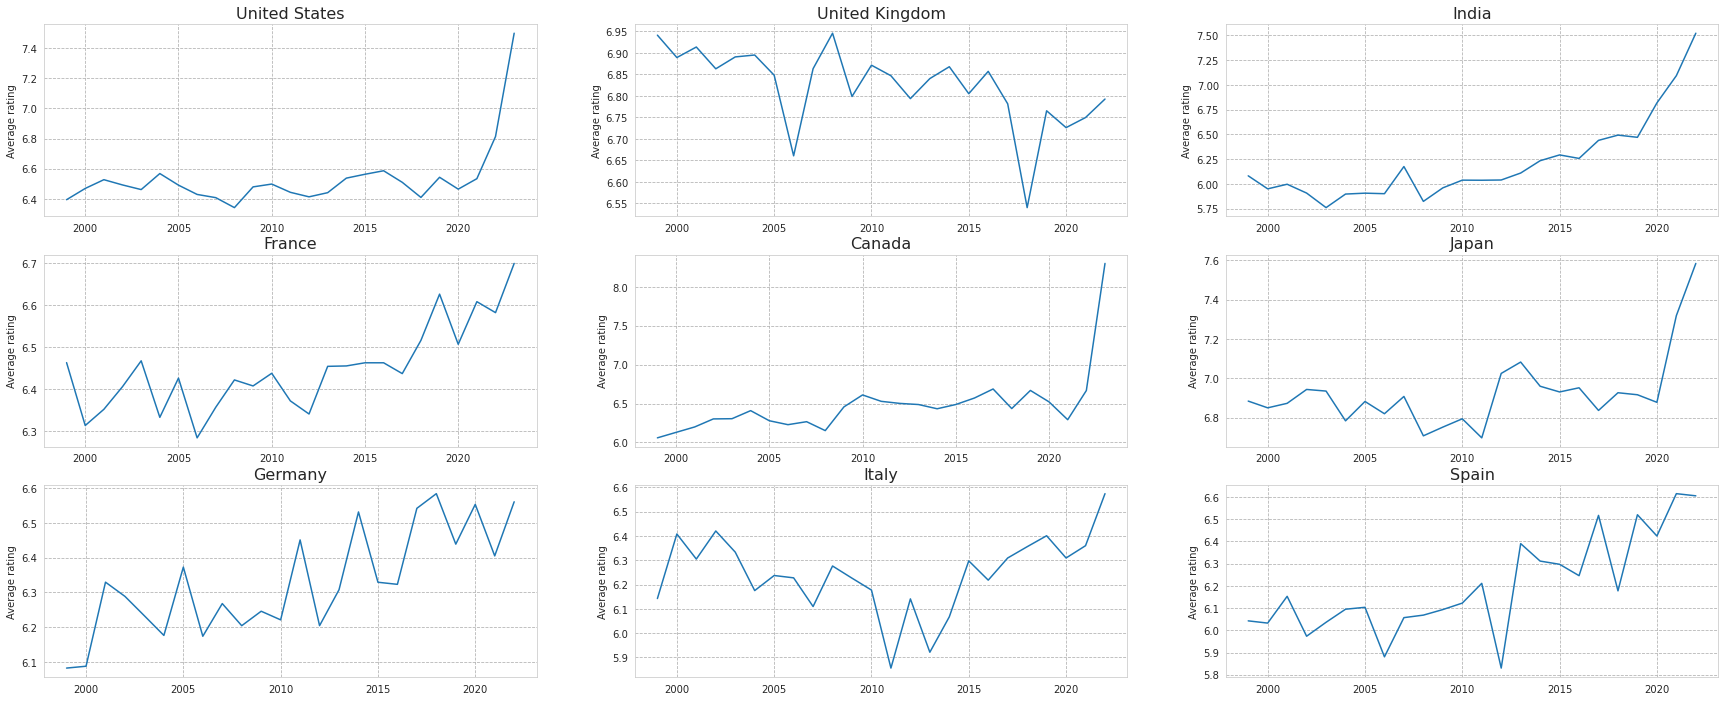

In [ ]:

fig1, axes = plt.subplots(3, 3, figsize=(30, 12))
for i, c in enumerate(movies_countries['country_of_origin'].unique()[:9]) :
    ax = axes[i // 3, i%3]
    m = avg_rating_by_countries_years[ (avg_rating_by_countries_years['country_of_origin']==c) &(avg_rating_by_countries_years['year']>1998)]
    ax.plot(m.year, m.average_rating)
    ax.set_title(c, fontsize=16)
    ax.set( ylabel='Average rating')

plt.show()

In [ ]:
avg_rating_by_countries_years[ avg_rating_by_countries_years['country_of_origin']=='Italy']

,country_of_origin,year,average_rating
829,Italy,1936,7.325000
1633,Italy,1926,6.966667
1641,Italy,1947,6.963636
1682,Italy,1943,6.950000
1875,Italy,1929,6.900000
...,...,...,...
5911,Italy,1908,5.300000
5927,Italy,1938,5.300000
5935,Italy,1944,5.300000
5995,Italy,1905,5.200000
